In [1]:
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit, Qubit, Instruction, Operation, CircuitInstruction
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile

from circuit_knitting.cutting import partition_problem, cut_gates, cut_wires

from cutter_search_manual import *
from resource_analysis import PhysicalParameters
from automation import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [2]:
from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator

workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

estimator = MicrosoftEstimator(workspace)


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 27
             Gate count: 39
    Nonlocal gate count: 14
         Gate breakdown: RZ: 19, CX: 14, RY: 4, RX: 2


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


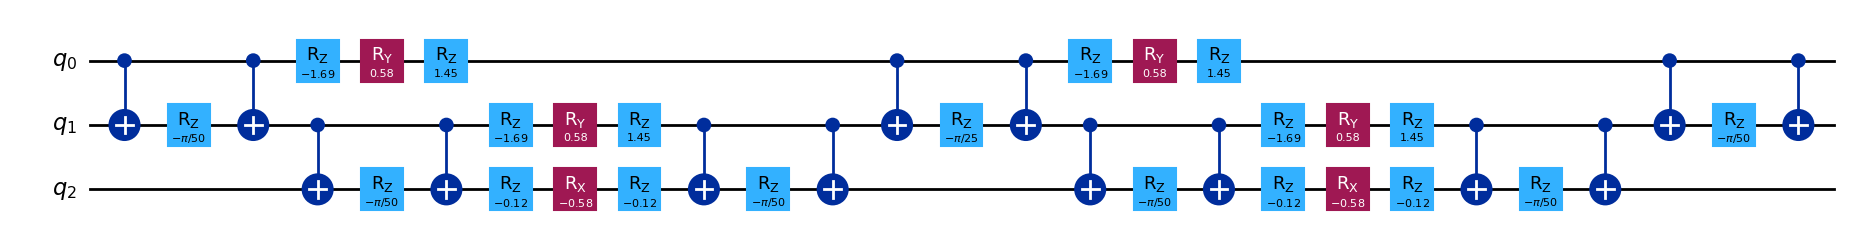

In [40]:
second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(2):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl", fold=-1)

In [4]:
# for ins in circuit.data:
#     print(ins)

In [5]:
# from qiskit.circuit.random import random_circuit
# circuit = random_circuit(7, 6, max_operands=2, seed=1242)
# circuit.draw('mpl', scale=0.8)

# Need two cut for one c-rot gate with bell pair? Difficult to locate...

In [6]:
# target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
# transpile_circ = transpile(circuit,
#                        basis_gates=target_basis, 
#                        optimization_level=1) 
# transpile_circ.draw('mpl', scale=0.5)

In [7]:
# from qiskit.converters import circuit_to_dag, dag_to_circuit
# dag = circuit_to_dag(transpile_circ)
# for layer in dag.layers():
#     layer_as_circuit = dag_to_circuit(layer['graph'])
#     for _inst in layer_as_circuit.data:
#         print(_inst.operation.name, [qubit._index for qubit in  _inst.qubits])

In [8]:
# from qiskit.circuit import CircuitInstruction
# from qiskit.circuit.library import Barrier

# _len = len(transpile_circ.data)
# for index, _instr in enumerate(reversed(transpile_circ.data)):
#     if _instr.operation.name == 'cx':
#         transpile_circ.data.insert(_len - index, CircuitInstruction(Barrier(transpile_circ.num_qubits), range(transpile_circ.num_qubits)))

# transpile_circ.draw('mpl', fold=-1)

In [9]:
# loc = {2,6}
# count = 0
# ins_id = 0
# p = True
# for ins in transpile_circ.data:
#     if ins.operation.name == 'barrier':
#         count += 1
#         p = True
#     if count in loc and p == True:
#         print(ins_id)
#         p = False
#     ins_id += 1
# print(count)

In [10]:
# from qiskit.transpiler.passes import RemoveBarriers
# subcirc_transpile, ancilla = bell_cuts(RemoveBarriers()(transpile_circ),[],{7-2:[1], 23-6:[1]}, True)

In [11]:
# ancilla.draw('mpl', scale=0.5)

In [12]:
# subcirc_transpile[0].draw('mpl', scale=0.5)

In [13]:
# job_t = backend_est.run(transpile_circ)
# result_t = job_t.result()
# result_t

In [14]:
# jobA_t = backend_est.run(map_subcirc(subcirc_transpile[0]))
# resultA_t = jobA_t.result()
# resultA_t

In [15]:
# jobB_t = backend_est.run(map_subcirc(subcirc_transpile[1]))
# resultB_t = jobB_t.result()
# resultB_t

# Bell cut, which is wrong

In [16]:
# subcirc = bell_cuts(circuit,[27],{19:[6]})

In [17]:
# subcirc[0].draw('mpl')

In [18]:
# subcirc[1].draw('mpl')

In [19]:
# job = backend_est.run(circuit)
# result = job.result()
# result

In [20]:
# jobA = backend_est.run(map_subcirc(subcirc[0]))
# resultA = jobA.result()
# resultA

In [21]:
# jobB = backend_est.run(map_subcirc(subcirc[1]))
# resultB = jobB.result()
# resultB

# Decomposition

Found solution using 4 cuts with a samplingoverhead of 65536.
Wire Cut at circuit instruction index 3
Wire Cut at circuit instruction index 19
Wire Cut at circuit instruction index 23
Wire Cut at circuit instruction index 39


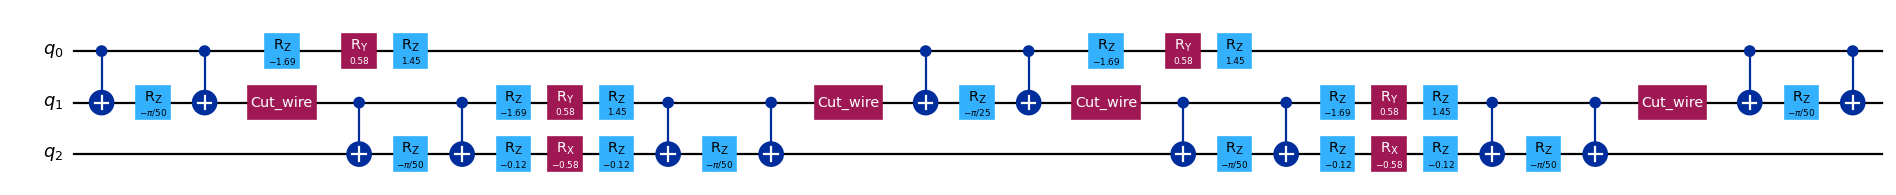

In [42]:
cut_circuit_dp, metadata = cuts(circuit,[],{3:[1],36:[1],17:[1],20:[1]})
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling'
    
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit_dp.draw("mpl", scale=0.8, fold=-1)

In [43]:
for i in cut_circuit_dp.data:
    print(i)

CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), clbits=())
CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.06283185307179587]), qubits=(Qubit(QuantumRegister(3, 'q'), 1),), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)), clbits=())
CircuitInstruction(operation=Instruction(name='cut_wire', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 1),), clbits=())
CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.6910198727717658]), qubits=(Qubit(QuantumRegister(3, 'q'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[0.5804906304278862]), qubits=(Qubit(QuantumRegister(3, 'q')

In [45]:

subcircuit = [QuantumCircuit(cut_circuit_dp.num_qubits-int(len(metadata["cuts"])/4)), QuantumCircuit(cut_circuit_dp.num_qubits-int(len(metadata["cuts"])/4))]
old_qubits = cut_circuit_dp.qubits
new_qubits = [c.qubits for c in subcircuit]
_Instruction = [[0,1,2,4,5,6,20,21,22, 24,25,26,40,41,42],[7,8,9,10,11,12,13,14,15,16,17,27,28,29,30,31,32,33,34,35,36,37,38]]
count = [0,0]
for idx, ins in enumerate(cut_circuit_dp.data):
    if idx in _Instruction[0]:
        if len(list(ins.qubits)) == 1:
            qb = new_qubits[0][old_qubits.index(ins.qubits[0])]
            subcircuit[0].data.insert(
                count[0],
                CircuitInstruction(
                    ins.operation,
                    [qb], []
                ),
                )  
        else:
            assert len(list(ins.qubits)) == 2
            qb1, qb2 = new_qubits[0][old_qubits.index(ins.qubits[0])], new_qubits[0][old_qubits.index(ins.qubits[1])]
            subcircuit[0].data.insert(
                count[0],
                CircuitInstruction(
                    ins.operation,
                    [qb1,qb2], []
                ),
                )   
        count[0] += 1
    elif idx in _Instruction[1]:
        if len(list(ins.qubits)) == 1:
            qb = new_qubits[1][old_qubits.index(ins.qubits[0])-1]
            subcircuit[1].data.insert(
                count[1],
                CircuitInstruction(
                    ins.operation,
                    [qb], []
                ),
                )  
        else:
            assert len(list(ins.qubits)) == 2
            qb1, qb2 = new_qubits[1][old_qubits.index(ins.qubits[0])-1], new_qubits[1][old_qubits.index(ins.qubits[1])-1]
            subcircuit[1].data.insert(
                count[1],
                CircuitInstruction(
                    ins.operation,
                    [qb1,qb2], []
                ),
                )   
        count[1] += 1
    else:
        continue

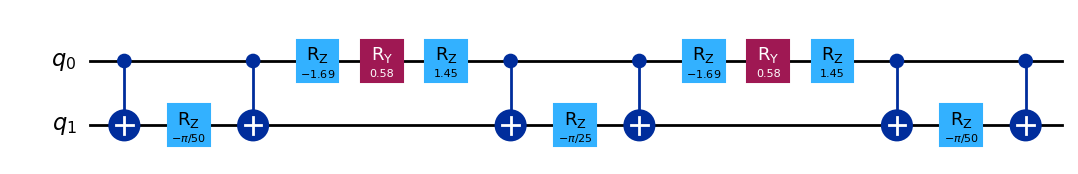

In [46]:
subcircuit[0].draw('mpl', fold=-1)

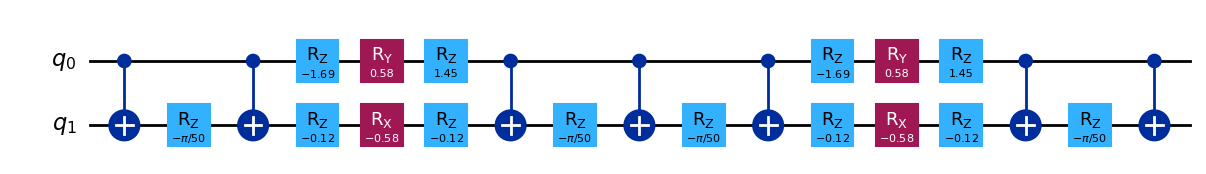

In [47]:
subcircuit[1].draw('mpl', fold=-1)

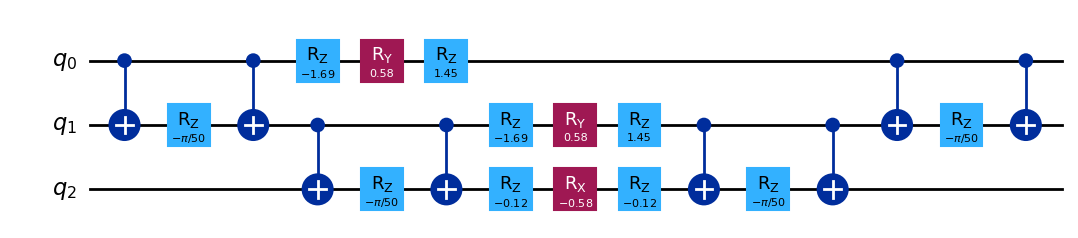

In [37]:
circuit.draw('mpl', fold=-1)

In [48]:
params = estimator.make_params(num_items=1)
# Error budget
params.error_budget = 0.01
params.constraints.max_t_factories = 1
job = estimator.submit(circuit, input_params=params)
r = job.get_results()
r['physicalCounts']['physicalQubits']
# Q = r['physicalCounts']['physicalQubits']
# T = r['physicalCounts']['runtime']*1e-3
# print('\n', 'total physical qubits required: ', Q, '\n', 'total runtime', T)

.......

9384

In [49]:
params1 = estimator.make_params(num_items=1)
params2 = estimator.make_params(num_items=1)
params1.constraints.max_t_factories = 1
params2.constraints.max_t_factories = 1
for (e1, e2) in [(0.001,0.009),(0.002,0.008),(0.003,0.007),(0.004,0.006),(0.005,0.005),(0.006,0.004),(0.007,0.003),(0.008,0.002),(0.009,0.001)]:
    params1.error_budget = e1
    job1 = estimator.submit(subcircuit[0], input_params=params1)
    r1 = job1.get_results()
    params2.error_budget = e2
    job2 = estimator.submit(subcircuit[1], input_params=params2)
    r2 = job2.get_results()
    print(r1['physicalCounts']['physicalQubits'],r2['physicalCounts']['physicalQubits'])

...........12222 8658
..........8658 8658
..........8658 8658
............8658 8658
..........8658 8658
..........8658 8658
...........8254 8658
...........7534 8658
..........5378 12722


......

Runtime,4 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 68 logical cycles to run the algorithm. If however the duration of a single T factory (here: 46,800 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,2.05M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (9) (with a logical error rate of 3.00e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,8.66k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 2,178 physical qubits to implement the algorithm logic, and 6,480 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,9,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 2$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 9$ logical qubits."
Algorithmic depth,68,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 8 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 12 multi-qubit measurements for each of the 5 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,1.02k,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 68. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,96,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 12 for each of the 8 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,1,"Number of T factories capable of producing the demanded 96 T states during the algorithm's runtime The total number of T factories 1 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{96 \cdot 46,800\;\text{ns}}{1 \cdot 4,496,800\;\text{ns}}\right\rceil$"
Number of T factory invocations,96,"Number of times all T factories are invoked In order to prepare the 96 T states, the 1 copies of the T factory are repeatedly invoked 96 times."
Physical algorithmic qubits,2.18k,"Number of physical qubits for the algorithm after layout The 2,178 are the product of the 9 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [30]:
# qc_w_ancilla_dp = cut_wires(cut_circuit_dp)
# qc_w_ancilla_dp.draw("mpl", scale=0.8, fold=-1)

In [31]:
# partitioned_problem_dp = partition_problem(circuit=qc_w_ancilla_dp)
# subcircuits_dp = partitioned_problem_dp.subcircuits
# print(
#     f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem_dp.bases])}"
# )

In [32]:
# s_dp1 = map_subcirc(subcircuits_dp[0],True)
# s_dp1.draw("mpl", scale=0.8)

In [33]:
# s_dp2 = map_subcirc(subcircuits_dp[1],True)
# s_dp2.draw("mpl", scale=0.8)

In [34]:
# job_d = backend_est.run(circuit)
# result_d = job_d.result()
# result_d

In [35]:
# job_d1 = backend_est.run(s_dp1)
# result_d1 = job_d1.result()
# result_d1

In [36]:
# job_d2 = backend_est.run(s_dp2)
# result_d2 = job_d2.result()
# result_d2